## Using neural networks to predict on Kryptonite-N dataset

In [85]:
import numpy as np
import os
import random
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from itertools import product

In [86]:
print(torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: {0}'.format(device))

myseed = 6095 

random.seed(myseed)
os.environ['PYTHONHASHSEED'] = str(myseed)
np.random.seed(myseed)
torch.manual_seed(myseed)
torch.cuda.manual_seed(myseed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True


2.5.1+cu118
Device: cuda


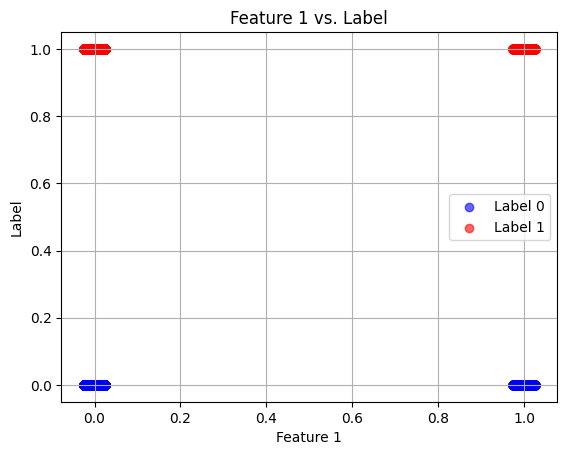

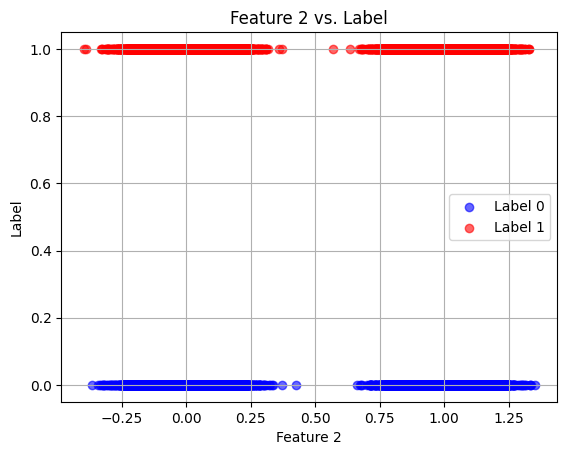

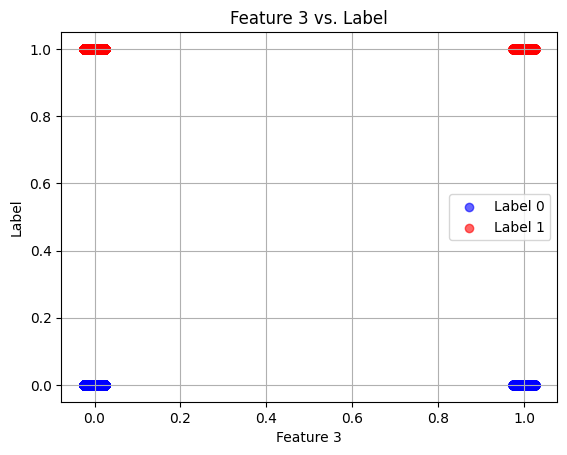

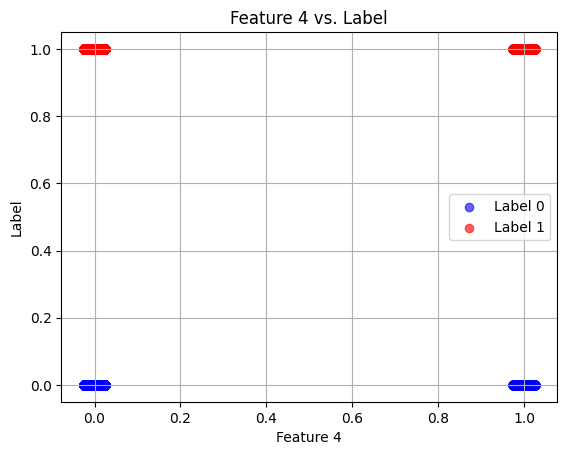

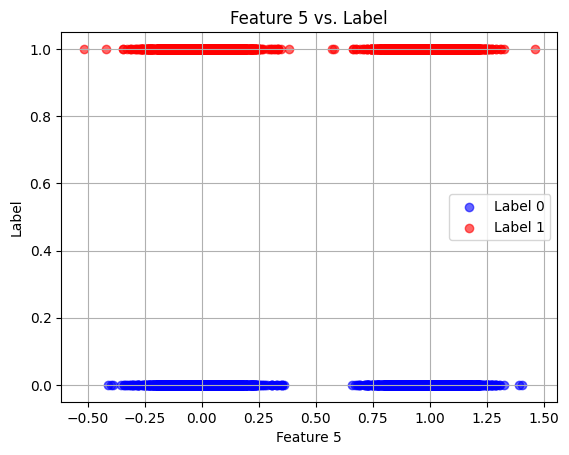

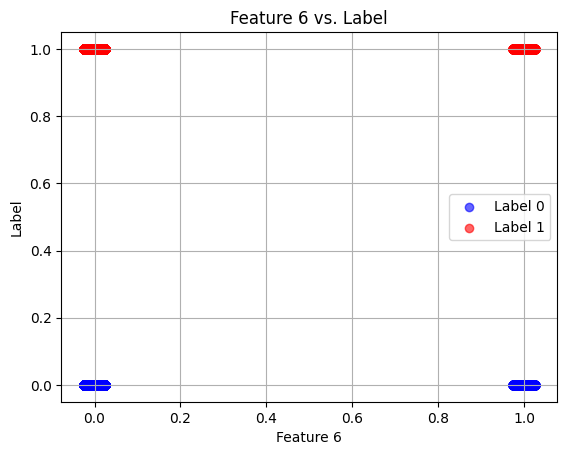

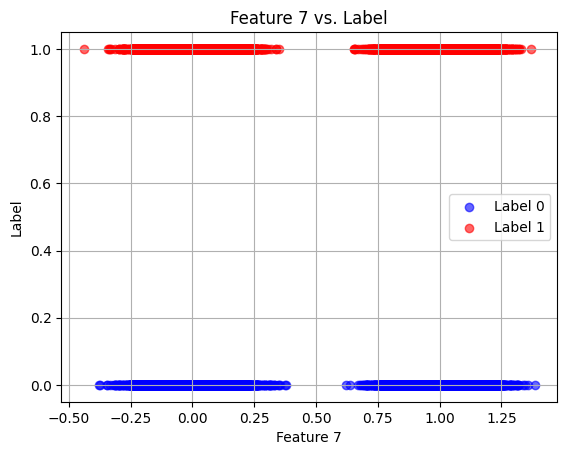

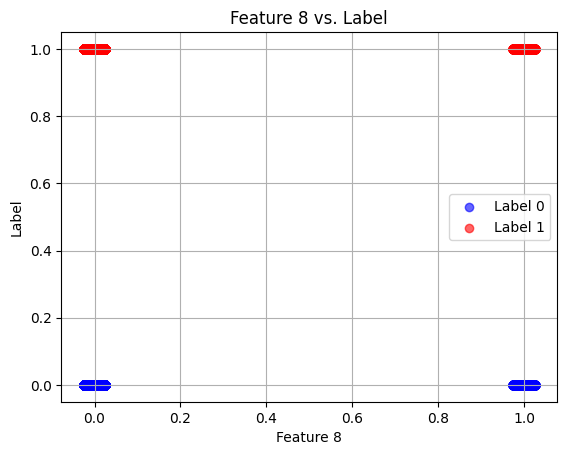

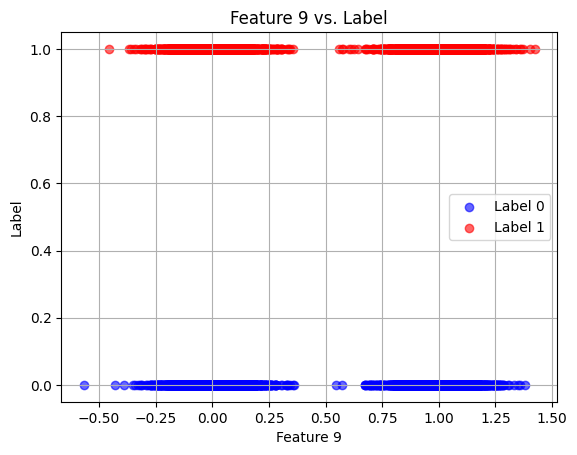

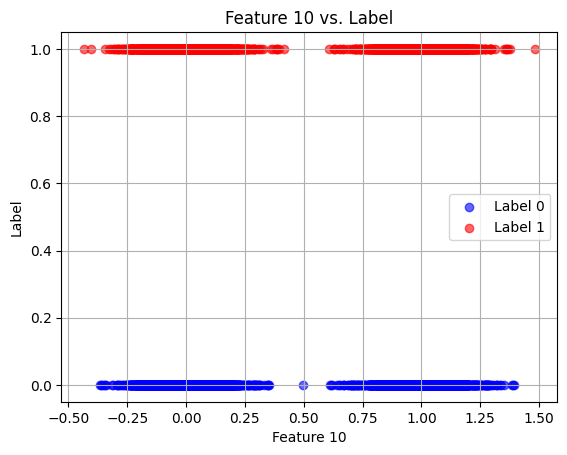

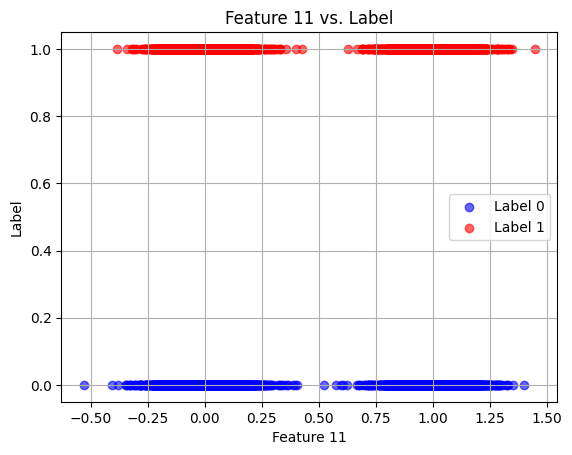

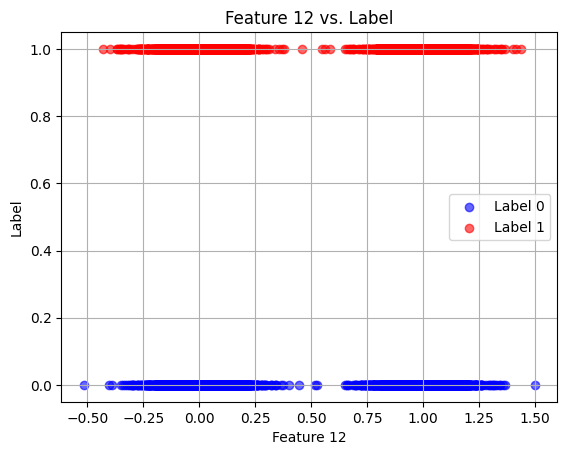

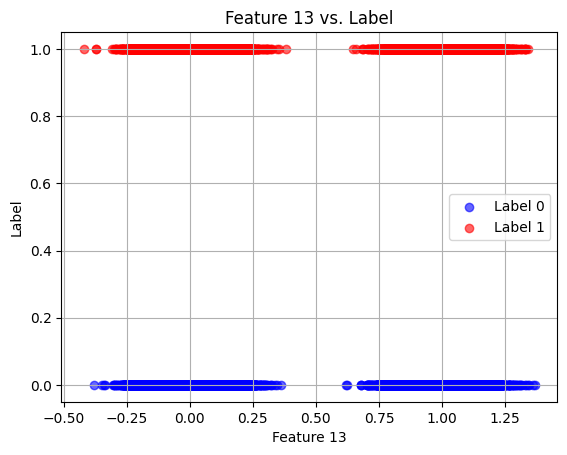

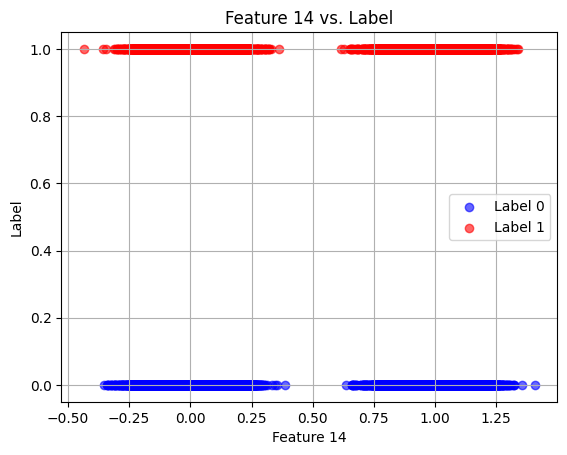

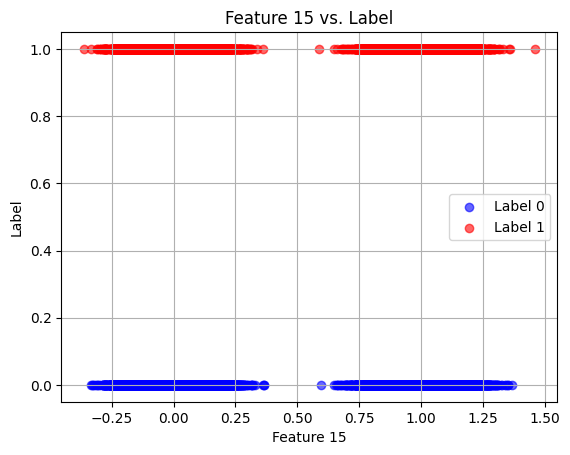

In [87]:
import matplotlib.pyplot as plt


def plot_features_vs_label(X, y):

    n_samples, n_features = X.shape
    
    assert y.shape == (n_samples,)
    assert set(np.unique(y)).issubset({0, 1})
    
    for i in range(n_features):
        plt.figure()
        
        plt.scatter(X[y == 0, i], [0] * sum(y == 0), color='blue', label='Label 0', alpha=0.6)
        plt.scatter(X[y == 1, i], [1] * sum(y == 1), color='red', label='Label 1', alpha=0.6)
        
        plt.xlabel(f'Feature {i+1}')
        plt.ylabel('Label')
        plt.title(f'Feature {i+1} vs. Label')
        plt.legend()
        plt.grid(True)
        
        plt.show()


n = 15
X = np.load('Datasets/kryptonite-%s-X.npy'%(n))
y = np.load('Datasets/kryptonite-%s-y.npy'%(n))

plot_features_vs_label(X, y)


In [88]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size=9, hidden_size=5, depth= 2):
        super().__init__()
        # self.linear_layer_stack = nn.Sequential(
        #     nn.Linear(input_size, hidden_size),
        #     nn.ReLU(),
        #     nn.Linear(hidden_size,hidden_size), 
        #     nn.ReLU(),
        #     nn.Linear(hidden_size,1), 
        # )



        modules = [torch.nn.Linear(input_size,hidden_size)]

        for i in range(depth-1):
            modules.append(torch.nn.Linear(hidden_size,hidden_size))
            modules.append(torch.nn.ReLU())

        modules.append(torch.nn.Linear(hidden_size, 1))

        self.linear_layer_stack = torch.nn.Sequential(
            *modules,
        )
 
        self._initialize_weights()  

    def _initialize_weights(self):
        for layer in self.linear_layer_stack:
            if isinstance(layer, nn.Linear):
                torch.nn.init.xavier_uniform_(layer.weight)
                torch.nn.init.zeros_(layer.bias)


    def forward(self, x):
        return self.linear_layer_stack(x)

In [89]:



# train_size = len(X_train)

def train_nn(model, dataloader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.unsqueeze(1).to(device)  # Move data to device
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(dataloader):.4f}')

        # if epoch%10 == 0:
        #     validate_nn(model, )



#### Validation

In [90]:
def validate_nn(model, X_val, y_val):
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val.to(device))
        val_outputs = torch.round(torch.sigmoid(val_outputs)).cpu().numpy()
        accuracy = accuracy_score(y_val, val_outputs)
    return accuracy

#### Grid Search Hyperparameter Tuning

In [91]:
def grid_search(X_train, y_train, X_val, y_val, param_grid, krypto_n):
    best_accuracy = 0
    best_params = None
    best_model = None
    
    for depth, hidden_size, learning_rate, batch_size, epochs in product(*param_grid.values()):
        print(f"Training with depth={depth}, hidden_size={hidden_size}, learning_rate={learning_rate}, batch_size={batch_size}, epochs={epochs}")
        
        model = NeuralNetwork(input_size=krypto_n, hidden_size=hidden_size, depth=depth).to(device)
        criterion = nn.BCEWithLogitsLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        
        train_dataset = TensorDataset(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        train_nn(model, train_loader, criterion, optimizer, epochs=epochs)
        
        accuracy = validate_nn(model, X_val, y_val)
        print(f"Validation Accuracy: {accuracy:.4f}")
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = {'depth':depth, 'hidden_size': hidden_size, 'learning_rate': learning_rate, 
                           'batch_size': batch_size, 'epochs': epochs}
            best_model = model

        print(f"Current best accuracy: {best_accuracy:.4f}")

    
    print("Best Parameters:", best_params)
    print("Best Validation Accuracy:", best_accuracy)
    print(f"Krypto variant: {krypto_n}")
    
    
    return best_model, best_params

#### Random Grid Search

In [92]:
def rand_grid_search(X_train, y_train, X_val, y_val, krypto_n):
    best_accuracy = 0
    best_params = None
    best_model = None
    
    combos = 0
    max_combos = 10

    while best_accuracy < 0.90:

        # hidden_sizes = param_grid['hidden_size']
        # learning_rates = param_grid~learning_rate']
        # batch_sizes = param_grid['batch_size']
        # epoch_list = param_grid['epochs']

        hidden_size = np.random.randint(80,700)
        learning_rate = np.random.uniform(0.0004, 0.002)
        batch_size = np.random.randint(64,4000)
        epochs = np.random.randint(5, 180)
        depth = np.random.randint(2,3)

        print(f"Training with depth={depth}, hidden_size={hidden_size}, learning_rate={learning_rate}, batch_size={batch_size}, epochs={epochs}")
        
        model = NeuralNetwork(input_size=krypto_n, hidden_size=hidden_size, depth=depth).to(device)
        criterion = nn.BCEWithLogitsLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        
        train_dataset = TensorDataset(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        train_nn(model, train_loader, criterion, optimizer, epochs=epochs)
        
        accuracy = validate_nn(model, X_val, y_val)
        print(f"Validation Accuracy: {accuracy:.4f}")
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = {'depth': depth, 'hidden_size': hidden_size, 'learning_rate': learning_rate, 
                           'batch_size': batch_size, 'epochs': epochs}
            best_model = model

        print(f"Current best accuracy: {best_accuracy:.4f}")
        combos += 1


    print("Best Parameters:", best_params)
    print("Best Validation Accuracy:", best_accuracy)
    print(f"Krypto variant: {krypto_n}")
    print(combos)
    return best_model, best_params

In [93]:
print(torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = "cpu"
print('Device: {0}'.format(device))

# setting kryptonite dataset no.
n = 24

# Reading and normalising dataset features for efficient convergence
scaler = StandardScaler()

# X = np.load('Datasets/kryptonite-%s-X.npy'%(n))
# y = np.load('Datasets/kryptonite-%s-y.npy'%(n))

X = np.load('Datasets/additional-kryptonite-%s-X.npy'%(n))
y = np.load('Datasets/additional-kryptonite-%s-y.npy'%(n))

X = scaler.fit_transform(X)

print((X[0]))

# Shuffle and split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.6, random_state=myseed)  # 60% training
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=myseed)  # 20% validation, 20% test

X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
X_val, y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)



2.5.1+cu118
Device: cuda
[-1.1078936  -1.0350703   1.134524    1.0359415  -1.0053867   0.7000379
  1.017131    1.0957041   0.6317573   1.0985615   0.80884194 -1.0358921
 -1.0203243   1.0048695  -0.99113226 -1.0277002  -1.0274432   0.95460474
  0.9603314  -0.800308    1.3219954  -0.96224827  0.770573    1.0219214 ]


In [ ]:

# param_grid = {
#     'depth': [2,4,8,16],
#     'hidden_size': [8, 16, 24, 30], 
#     'learning_rate': [0.001, 0.005, 0.01, 0.05 , 0.1], 
#     'batch_size': [16, 32, 64, 96],     
#     'epochs': [5, 10, 20, 30]              
# }

# Dictionary of hyperparameter values to search through

# param_grid = {
#     'depth': [2],
#     'hidden_size': [82],
#     'learning_rate': [0.00241],
#     'batch_size': [63],     
#     'epochs': [158]               
# }


# best_model, best_params = grid_search(X_train, y_train, X_val, y_val, param_grid, n)

best_model, best_params = rand_grid_search(X_train, y_train, X_val, y_val, n)


# Current Hyperparameters for each Kryptonite Variant:

# Best Parameters: {'depth': 3, 'hidden_size': 38, 'learning_rate': 0.00141, 'batch_size': 140, 'epochs': 35}
# Best Validation Accuracy: 0.9527777777777777
# Test Accuracy = 0.9566666666666667
# Krypto variant: 9


# Best Parameters: {'depth': 2, 'hidden_size': 84, 'learning_rate': 0.002226459276380165, 'batch_size': 155, 'epochs': 146}
# Best Validation Accuracy: 0.9452777777777778
# Test Accuracy = 0.9497222222222222
# Krypto variant: 12


# Best Parameters: {'depth': 2, 'hidden_size': 54, 'learning_rate': 0.002077090842646019, 'batch_size': 147, 'epochs': 165}
# Best Validation Accuracy: 0.9342222222222222
# Test Accuracy = 0.9304444444444444
# Krypto variant: 15

# Current best accuracy: 0.9048
# Best Parameters: {'depth': 2, 'hidden_size': 97, 'learning_rate': 0.002937306209994177, 'batch_size': 100, 'epochs': 72}
# Best Validation Accuracy: 0.9048148148148148
# Test Accuracy = 0.9057407407407407
# Krypto variant: 18

# Training with depth=2, hidden_size=84, learning_rate=0.0008952525037794653, batch_size=155, epochs=146
# Validation Accuracy: 0.9427
# Krypto variant: 15

# Best Parameters: {'depth': 2, 'hidden_size': 150, 'learning_rate': 0.0007625120811532073, 'batch_size': 443, 'epochs': 45}
# Best Validation Accuracy: 0.86016
# Test Accuracy = 0.8596933333333333
# Krypto variant: 24

# Best Parameters: {'depth': 2, 'hidden_size': 388, 'learning_rate': 0.000522646472592812, 'batch_size': 485, 'epochs': 156}
# Best Validation Accuracy: 0.9032266666666666
# Krypto variant: 24



Training with depth=2, hidden_size=670, learning_rate=0.00048438873747831847, batch_size=3173, epochs=114
Epoch 1/114, Loss: 0.6978
Epoch 2/114, Loss: 0.6934
Epoch 3/114, Loss: 0.6919
Epoch 4/114, Loss: 0.6909
Epoch 5/114, Loss: 0.6904
Epoch 6/114, Loss: 0.6897
Epoch 7/114, Loss: 0.6887
Epoch 8/114, Loss: 0.6883
Epoch 9/114, Loss: 0.6879
Epoch 10/114, Loss: 0.6873
Epoch 11/114, Loss: 0.6858
Epoch 12/114, Loss: 0.6856
Epoch 13/114, Loss: 0.6852
Epoch 14/114, Loss: 0.6843
Epoch 15/114, Loss: 0.6830
Epoch 16/114, Loss: 0.6825
Epoch 17/114, Loss: 0.6820
Epoch 18/114, Loss: 0.6809
Epoch 19/114, Loss: 0.6795
Epoch 20/114, Loss: 0.6784
Epoch 21/114, Loss: 0.6770
Epoch 22/114, Loss: 0.6757
Epoch 23/114, Loss: 0.6751
Epoch 24/114, Loss: 0.6738
Epoch 25/114, Loss: 0.6720
Epoch 26/114, Loss: 0.6699
Epoch 27/114, Loss: 0.6689
Epoch 28/114, Loss: 0.6670
Epoch 29/114, Loss: 0.6648
Epoch 30/114, Loss: 0.6633
Epoch 31/114, Loss: 0.6605
Epoch 32/114, Loss: 0.6580
Epoch 33/114, Loss: 0.6555
Epoch 34/114

In [95]:
def test_nn(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test.to(device))
        test_outputs = torch.round(torch.sigmoid(test_outputs)).cpu().numpy()
        accuracy = accuracy_score(y_test, test_outputs)
    return accuracy


test_accuracy = test_nn(best_model, X_test, y_test)
print(f"Test Accuracy = {test_accuracy}")

Test Accuracy = 0.9046133333333334
